### IMPORT THE LIBRARIES

In [1]:
from __future__ import print_function, division
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import music21
from music21 import converter, instrument, note, chord, stream
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Reshape, Dropout, CuDNNLSTM, Bidirectional, LSTM
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tqdm
from tqdm import tqdm, tqdm_notebook
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


In [2]:
#check if GPU is available
gpu = tf.test.is_gpu_available()
gpu

True

In [3]:
#provide the path to our dataset
data_path = "../mid2txt/mid-files"
def get_notes():
    """ Get all the notes and chords from the midi files """
    
    notes = []
    
    folders_all = [f for f in os.listdir(data_path)]
    files = [os.path.join(data_path, f) for f in folders_all]
    mid_files = [glob.glob(files[i] + "/" + "*.mid") for i in range(len(files))]
    combine = [l for ls in mid_files for l in ls]
    needed_files = [f for f in combine if "format0" not in f]
        
    for file in tqdm_notebook(needed_files):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

In [4]:
#call the above "get_notes" function which will parse all the MIDI files
our_notes = get_notes()

Parsing ../mid2txt/mid-files\albeniz\alb_esp1.mid
Parsing ../mid2txt/mid-files\albeniz\alb_esp2.mid
Parsing ../mid2txt/mid-files\albeniz\alb_esp3.mid
Parsing ../mid2txt/mid-files\albeniz\alb_esp4.mid
Parsing ../mid2txt/mid-files\albeniz\alb_esp5.mid
Parsing ../mid2txt/mid-files\albeniz\alb_esp6.mid
Parsing ../mid2txt/mid-files\albeniz\alb_se1.mid
Parsing ../mid2txt/mid-files\albeniz\alb_se2.mid
Parsing ../mid2txt/mid-files\albeniz\alb_se3.mid
Parsing ../mid2txt/mid-files\albeniz\alb_se4.mid
Parsing ../mid2txt/mid-files\albeniz\alb_se5.mid
Parsing ../mid2txt/mid-files\albeniz\alb_se7.mid
Parsing ../mid2txt/mid-files\albeniz\alb_se8.mid
Parsing ../mid2txt/mid-files\bach\bach_846.mid
Parsing ../mid2txt/mid-files\bach\bach_847.mid
Parsing ../mid2txt/mid-files\bach\bach_850.mid
Parsing ../mid2txt/mid-files\balakirew\islamei.mid
Parsing ../mid2txt/mid-files\beethoven\appass_1.mid
Parsing ../mid2txt/mid-files\beethoven\appass_2.mid
Parsing ../mid2txt/mid-files\beethoven\appass_3.mid
Parsing .

Parsing ../mid2txt/mid-files\grieg\grieg_zwerge.mid
Parsing ../mid2txt/mid-files\haydn\haydn_33_1.mid
Parsing ../mid2txt/mid-files\haydn\haydn_33_2.mid
Parsing ../mid2txt/mid-files\haydn\haydn_33_3.mid
Parsing ../mid2txt/mid-files\haydn\haydn_35_1.mid
Parsing ../mid2txt/mid-files\haydn\haydn_35_2.mid
Parsing ../mid2txt/mid-files\haydn\haydn_35_3.mid
Parsing ../mid2txt/mid-files\haydn\haydn_43_2.mid
Parsing ../mid2txt/mid-files\haydn\haydn_43_3.mid
Parsing ../mid2txt/mid-files\haydn\haydn_7_1.mid
Parsing ../mid2txt/mid-files\haydn\haydn_7_2.mid
Parsing ../mid2txt/mid-files\haydn\haydn_7_3.mid
Parsing ../mid2txt/mid-files\haydn\haydn_8_1.mid
Parsing ../mid2txt/mid-files\haydn\haydn_8_2.mid
Parsing ../mid2txt/mid-files\haydn\haydn_8_3.mid
Parsing ../mid2txt/mid-files\haydn\haydn_8_4.mid
Parsing ../mid2txt/mid-files\haydn\haydn_9_1.mid
Parsing ../mid2txt/mid-files\haydn\haydn_9_2.mid
Parsing ../mid2txt/mid-files\haydn\haydn_9_3.mid
Parsing ../mid2txt/mid-files\haydn\hay_40_2.mid
Parsing ..

In [39]:
#here we will prepare our input and output sequences
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 200 #the length of each sequence

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    
    #creating an empty lists to hold up our input and ouput sequences
    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in tqdm_notebook(range(0, len(notes) - sequence_length, 1)):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # Normalize input between -1 and 1
    network_input = (network_input - float(n_vocab)/2) / (float(n_vocab)/2)
    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [40]:
#call the above function and generate our input and output sequences
#X_train ---> Will hold our data on which model will be trained
#y_train ---> output for our model
n_vocab = len(set(our_notes))
X_train, y_train = prepare_sequences(our_notes, n_vocab)

### BUILD GENERATOR

In [41]:
rows = 200
latent_dim = 1000 #dimension of our latent space which will be used by the generator to generate random output
seq_length = rows #length of our each sequence
seq_shape = (seq_length, 1)
def build_generator():
        #we will be using keras's sequential API for building our generator
        model = Sequential()
        model.add(Dense(256, input_dim = latent_dim))
        #the study has found that using "LeakyRelu" as an activation function produces better result than using "Relu"
        model.add(LeakyReLU(alpha = 0.2))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(Dense(np.prod(seq_shape), activation = 'tanh'))
        model.add(Reshape(seq_shape))
        model.summary()  
        noise = Input(shape = (latent_dim, ))
        seq = model(noise)

        return Model(noise, seq)

In [42]:
generator = build_generator()
#generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               256256    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
__________

### BUILD DISCRIMINATOR

In [43]:
#building the discriminator
def build_discriminator():
        model = Sequential()
        #if gpu is available the model will use CuDNNLSTM else it will use LSTM
        if gpu:
            model.add(CuDNNLSTM(512, input_shape = seq_shape, return_sequences = True))
            model.add(Bidirectional(CuDNNLSTM(512)))
        else:
            model.add(LSTM(512, input_shape = seq_shape, return_sequences = True))
            model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dense(1, activation = 'sigmoid'))
        model.summary()
        seq = Input(shape = seq_shape)
        validity = model(seq)

        return Model(seq, validity)

In [44]:
#call the above "build_discriminator" function
discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 200, 512)          1054720   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              4202496   
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total para

### COMBINING GENERATOR AND DISCRIMINATOR

In [45]:
def GAN(rows, generator, discriminator):
    """
    rows ---> 200
    generator ---> our generator model
    discriminator ---> our discriminator model
    """
    
    optimizer = Adam(lr = 0.0001, beta_1 = 0.5)

    # compile the discriminator
    discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    # The generator takes noise as input and generates note sequences
    z = Input(shape = (latent_dim,))
    generated_seq = generator(z)

    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = discriminator(generated_seq)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    combined_model = Model(z, validity)
    combined_model.summary()
    combined_model.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    return combined_model

In [46]:
#build the final GAN model
gan_model = GAN(rows, generator, discriminator)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
model_5 (Model)              (None, 200, 1)            1125320   
_________________________________________________________________
model_6 (Model)              (None, 1)                 5913601   
Total params: 7,038,921
Trainable params: 1,121,736
Non-trainable params: 5,917,185
_________________________________________________________________


### GENERATE NEW SAMPLES

In [47]:
#The follwoing function takes the predictions from the model as input along with the file name and creates a MIDI file for us
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp = '{}.mid'.format(filename))
    
def generate(input_notes):
    # Get pitch names and store in a dictionary
    notes = input_notes
    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        
    # Use random noise to generate sequences
    noise = np.random.normal(0, 1, (1, latent_dim))
    
    #predictions on a random noise from our trained generator model
    predictions = generator.predict(noise) 
        
    #select a random point from the predictions above to generate a MIDI file
    #this is the first file we will be generating
    pred_notes3 = [x*105+200 for x in predictions[0]]
    pred_notes3 = [int_to_note[int(x)] for x in pred_notes3]
    
    #select a random point from the predictions above to generate a MIDI file
    #this is the second file we will be generating
    pred_notes4 = [x*180+200 for x in predictions[0]]
    pred_notes4 = [int_to_note[int(x)] for x in pred_notes4]
    
    #here we are creating 2 MIDI files from the traineg model
    create_midi(pred_notes3, 'gan_final_3')
    create_midi(pred_notes4, "gan_final_4")

### TRAIN THE GAN

In [48]:
#the following function will train our data on the model
def train(our_notes, X_train, y_train, generator, discriminator, combined_model, epochs, batch_size = 128, sample_interval = 1):
    """
    our_notes --> The parsed notes from the MIDI files
    X_train --> The input features to our model
    y_train --> The actual labels to the model
    generator --> Our generator model
    discriminator --> Discriminator model
    combined_model --> Combined generator and discriminator
    epochs --> Total number of epochs our model will be trianed for
    batch_size --> The number of samples the model will see during each epoch
    """
        
    #store the discriminator and generator loss for each epoch
    disc_loss = []
    gen_loss = []
        
    # Load and convert the data
    notes = our_notes
    n_vocab = len(set(notes))

    # Adversarial ground truths
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
        
    # Training the model
    for epoch in range(epochs):

        # Training the discriminator
        # Select a random batch of note sequences
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_seqs = X_train[idx]

        #selecting a random point from the latent space
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new note sequences
        gen_seqs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_seqs, real)
        d_loss_fake = discriminator.train_on_batch(gen_seqs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        #  Training the Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as real)
        g_loss = combined_model.train_on_batch(noise, real)

        # Print the progress and save into loss lists
        if epoch % sample_interval == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            disc_loss.append(d_loss[0])
            gen_loss.append(g_loss)
    generate(notes)
    return disc_loss, gen_loss

In [49]:
#call the above "train" method to train our model
#the "train" function returns two outputs 1-->discrimminator loss 2-->generator loss
model_train = train(our_notes, X_train, y_train, generator, discriminator, gan_model, 3000, 32, 1)

0 [D loss: 0.696224, acc.: 3.12%] [G loss: 0.691728]
1 [D loss: 0.681947, acc.: 65.62%] [G loss: 0.690813]
2 [D loss: 0.668179, acc.: 68.75%] [G loss: 0.689652]
3 [D loss: 0.650926, acc.: 65.62%] [G loss: 0.694852]
4 [D loss: 0.631975, acc.: 65.62%] [G loss: 0.698080]
5 [D loss: 0.572529, acc.: 76.56%] [G loss: 0.703769]
6 [D loss: 0.480866, acc.: 70.31%] [G loss: 0.770980]
7 [D loss: 0.331445, acc.: 90.62%] [G loss: 1.079695]
8 [D loss: 0.212160, acc.: 95.31%] [G loss: 2.112478]
9 [D loss: 0.224276, acc.: 93.75%] [G loss: 4.140122]
10 [D loss: 0.099942, acc.: 98.44%] [G loss: 3.900174]
11 [D loss: 0.105397, acc.: 95.31%] [G loss: 4.468600]
12 [D loss: 0.118401, acc.: 96.88%] [G loss: 4.364483]
13 [D loss: 0.063927, acc.: 98.44%] [G loss: 4.077464]
14 [D loss: 0.183005, acc.: 96.88%] [G loss: 3.061067]
15 [D loss: 0.166270, acc.: 95.31%] [G loss: 2.477663]
16 [D loss: 0.092742, acc.: 98.44%] [G loss: 2.951229]
17 [D loss: 0.091577, acc.: 95.31%] [G loss: 3.712000]
18 [D loss: 0.097775,

294 [D loss: 0.496406, acc.: 75.00%] [G loss: 1.657674]
295 [D loss: 0.638603, acc.: 67.19%] [G loss: 1.503205]
296 [D loss: 0.511062, acc.: 70.31%] [G loss: 1.404191]
297 [D loss: 0.587251, acc.: 70.31%] [G loss: 1.445336]
298 [D loss: 0.584172, acc.: 68.75%] [G loss: 1.402403]
299 [D loss: 0.528190, acc.: 73.44%] [G loss: 1.506472]
300 [D loss: 0.534271, acc.: 73.44%] [G loss: 1.409696]
301 [D loss: 0.642161, acc.: 62.50%] [G loss: 1.164951]
302 [D loss: 0.615480, acc.: 67.19%] [G loss: 1.144050]
303 [D loss: 0.666078, acc.: 59.38%] [G loss: 1.119055]
304 [D loss: 0.510396, acc.: 79.69%] [G loss: 1.364028]
305 [D loss: 0.539886, acc.: 75.00%] [G loss: 1.418817]
306 [D loss: 0.608806, acc.: 64.06%] [G loss: 1.345488]
307 [D loss: 0.444596, acc.: 78.12%] [G loss: 1.858449]
308 [D loss: 0.688246, acc.: 65.62%] [G loss: 1.213404]
309 [D loss: 0.591628, acc.: 70.31%] [G loss: 1.199935]
310 [D loss: 0.620141, acc.: 68.75%] [G loss: 1.194940]
311 [D loss: 0.521879, acc.: 76.56%] [G loss: 1.

586 [D loss: 0.635268, acc.: 59.38%] [G loss: 0.802199]
587 [D loss: 0.675216, acc.: 64.06%] [G loss: 0.827433]
588 [D loss: 0.668102, acc.: 65.62%] [G loss: 0.826645]
589 [D loss: 0.648884, acc.: 60.94%] [G loss: 0.804637]
590 [D loss: 0.681182, acc.: 53.12%] [G loss: 0.825575]
591 [D loss: 0.628203, acc.: 59.38%] [G loss: 0.852989]
592 [D loss: 0.677554, acc.: 57.81%] [G loss: 0.828884]
593 [D loss: 0.611352, acc.: 57.81%] [G loss: 0.900617]
594 [D loss: 0.727598, acc.: 54.69%] [G loss: 0.819519]
595 [D loss: 0.627203, acc.: 70.31%] [G loss: 0.807545]
596 [D loss: 0.679295, acc.: 60.94%] [G loss: 0.803783]
597 [D loss: 0.669842, acc.: 60.94%] [G loss: 0.783675]
598 [D loss: 0.688944, acc.: 51.56%] [G loss: 0.789688]
599 [D loss: 0.659352, acc.: 59.38%] [G loss: 0.791349]
600 [D loss: 0.633504, acc.: 64.06%] [G loss: 0.822261]
601 [D loss: 0.689504, acc.: 56.25%] [G loss: 0.827703]
602 [D loss: 0.646876, acc.: 62.50%] [G loss: 0.825561]
603 [D loss: 0.695583, acc.: 53.12%] [G loss: 0.

878 [D loss: 0.684474, acc.: 56.25%] [G loss: 0.691816]
879 [D loss: 0.695948, acc.: 50.00%] [G loss: 0.689516]
880 [D loss: 0.680685, acc.: 62.50%] [G loss: 0.684971]
881 [D loss: 0.699409, acc.: 43.75%] [G loss: 0.680625]
882 [D loss: 0.694562, acc.: 46.88%] [G loss: 0.687758]
883 [D loss: 0.697072, acc.: 48.44%] [G loss: 0.687404]
884 [D loss: 0.686110, acc.: 59.38%] [G loss: 0.683967]
885 [D loss: 0.703210, acc.: 40.62%] [G loss: 0.686607]
886 [D loss: 0.694621, acc.: 51.56%] [G loss: 0.685433]
887 [D loss: 0.693354, acc.: 43.75%] [G loss: 0.692443]
888 [D loss: 0.701400, acc.: 45.31%] [G loss: 0.689658]
889 [D loss: 0.710328, acc.: 34.38%] [G loss: 0.694413]
890 [D loss: 0.699881, acc.: 48.44%] [G loss: 0.697132]
891 [D loss: 0.697708, acc.: 42.19%] [G loss: 0.697072]
892 [D loss: 0.697154, acc.: 42.19%] [G loss: 0.699186]
893 [D loss: 0.693923, acc.: 51.56%] [G loss: 0.695354]
894 [D loss: 0.700287, acc.: 32.81%] [G loss: 0.696769]
895 [D loss: 0.696652, acc.: 43.75%] [G loss: 0.

1166 [D loss: 0.693765, acc.: 51.56%] [G loss: 0.705753]
1167 [D loss: 0.694065, acc.: 48.44%] [G loss: 0.701125]
1168 [D loss: 0.689663, acc.: 57.81%] [G loss: 0.706005]
1169 [D loss: 0.692000, acc.: 56.25%] [G loss: 0.704493]
1170 [D loss: 0.693420, acc.: 53.12%] [G loss: 0.706019]
1171 [D loss: 0.689279, acc.: 57.81%] [G loss: 0.705980]
1172 [D loss: 0.695354, acc.: 50.00%] [G loss: 0.699092]
1173 [D loss: 0.692685, acc.: 46.88%] [G loss: 0.706848]
1174 [D loss: 0.693692, acc.: 53.12%] [G loss: 0.707246]
1175 [D loss: 0.693873, acc.: 53.12%] [G loss: 0.705429]
1176 [D loss: 0.692059, acc.: 57.81%] [G loss: 0.710378]
1177 [D loss: 0.692646, acc.: 48.44%] [G loss: 0.724578]
1178 [D loss: 0.693440, acc.: 54.69%] [G loss: 0.722068]
1179 [D loss: 0.693133, acc.: 51.56%] [G loss: 0.731526]
1180 [D loss: 0.700689, acc.: 37.50%] [G loss: 0.712702]
1181 [D loss: 0.690045, acc.: 51.56%] [G loss: 0.712524]
1182 [D loss: 0.692396, acc.: 51.56%] [G loss: 0.701148]
1183 [D loss: 0.689749, acc.: 5

1452 [D loss: 0.687426, acc.: 56.25%] [G loss: 0.702500]
1453 [D loss: 0.695014, acc.: 53.12%] [G loss: 0.698141]
1454 [D loss: 0.685211, acc.: 56.25%] [G loss: 0.697695]
1455 [D loss: 0.689412, acc.: 50.00%] [G loss: 0.713081]
1456 [D loss: 0.690086, acc.: 48.44%] [G loss: 0.706346]
1457 [D loss: 0.697612, acc.: 42.19%] [G loss: 0.708716]
1458 [D loss: 0.685959, acc.: 54.69%] [G loss: 0.695348]
1459 [D loss: 0.686834, acc.: 65.62%] [G loss: 0.702872]
1460 [D loss: 0.685528, acc.: 57.81%] [G loss: 0.695152]
1461 [D loss: 0.684010, acc.: 60.94%] [G loss: 0.698857]
1462 [D loss: 0.696757, acc.: 50.00%] [G loss: 0.704433]
1463 [D loss: 0.684357, acc.: 57.81%] [G loss: 0.725605]
1464 [D loss: 0.679707, acc.: 62.50%] [G loss: 0.726556]
1465 [D loss: 0.711939, acc.: 42.19%] [G loss: 0.724057]
1466 [D loss: 0.694152, acc.: 46.88%] [G loss: 0.717107]
1467 [D loss: 0.688604, acc.: 54.69%] [G loss: 0.712482]
1468 [D loss: 0.689968, acc.: 51.56%] [G loss: 0.727461]
1469 [D loss: 0.700295, acc.: 4

1738 [D loss: 0.689067, acc.: 54.69%] [G loss: 0.711280]
1739 [D loss: 0.689181, acc.: 59.38%] [G loss: 0.726108]
1740 [D loss: 0.686134, acc.: 53.12%] [G loss: 0.764312]
1741 [D loss: 0.720600, acc.: 39.06%] [G loss: 0.712066]
1742 [D loss: 0.691884, acc.: 51.56%] [G loss: 0.714893]
1743 [D loss: 0.697537, acc.: 51.56%] [G loss: 0.712265]
1744 [D loss: 0.696000, acc.: 42.19%] [G loss: 0.709505]
1745 [D loss: 0.694698, acc.: 46.88%] [G loss: 0.710645]
1746 [D loss: 0.699106, acc.: 45.31%] [G loss: 0.711097]
1747 [D loss: 0.694609, acc.: 48.44%] [G loss: 0.710172]
1748 [D loss: 0.700220, acc.: 35.94%] [G loss: 0.709351]
1749 [D loss: 0.691969, acc.: 53.12%] [G loss: 0.708367]
1750 [D loss: 0.693680, acc.: 57.81%] [G loss: 0.704817]
1751 [D loss: 0.696492, acc.: 46.88%] [G loss: 0.704601]
1752 [D loss: 0.695536, acc.: 50.00%] [G loss: 0.706767]
1753 [D loss: 0.696931, acc.: 48.44%] [G loss: 0.702225]
1754 [D loss: 0.694174, acc.: 43.75%] [G loss: 0.700817]
1755 [D loss: 0.694464, acc.: 4

2024 [D loss: 0.689872, acc.: 54.69%] [G loss: 0.708062]
2025 [D loss: 0.688945, acc.: 53.12%] [G loss: 0.689054]
2026 [D loss: 0.687266, acc.: 56.25%] [G loss: 0.675038]
2027 [D loss: 0.685675, acc.: 57.81%] [G loss: 0.684418]
2028 [D loss: 0.691241, acc.: 51.56%] [G loss: 0.690504]
2029 [D loss: 0.700322, acc.: 43.75%] [G loss: 0.713382]
2030 [D loss: 0.681152, acc.: 64.06%] [G loss: 0.736887]
2031 [D loss: 0.691008, acc.: 51.56%] [G loss: 0.719583]
2032 [D loss: 0.688690, acc.: 60.94%] [G loss: 0.754856]
2033 [D loss: 0.692374, acc.: 50.00%] [G loss: 0.756519]
2034 [D loss: 0.695302, acc.: 50.00%] [G loss: 0.748596]
2035 [D loss: 0.701774, acc.: 48.44%] [G loss: 0.762083]
2036 [D loss: 0.673828, acc.: 53.12%] [G loss: 1.523029]
2037 [D loss: 1.960886, acc.: 4.69%] [G loss: 1.630481]
2038 [D loss: 1.235486, acc.: 46.88%] [G loss: 0.818398]
2039 [D loss: 0.783316, acc.: 31.25%] [G loss: 0.782239]
2040 [D loss: 0.710704, acc.: 21.88%] [G loss: 1.212940]
2041 [D loss: 0.812625, acc.: 34

2311 [D loss: 0.695574, acc.: 37.50%] [G loss: 0.704985]
2312 [D loss: 0.696840, acc.: 31.25%] [G loss: 0.699900]
2313 [D loss: 0.698247, acc.: 32.81%] [G loss: 0.699921]
2314 [D loss: 0.697660, acc.: 34.38%] [G loss: 0.701865]
2315 [D loss: 0.696529, acc.: 29.69%] [G loss: 0.701508]
2316 [D loss: 0.695648, acc.: 43.75%] [G loss: 0.701411]
2317 [D loss: 0.695208, acc.: 45.31%] [G loss: 0.705224]
2318 [D loss: 0.693224, acc.: 54.69%] [G loss: 0.702082]
2319 [D loss: 0.695359, acc.: 48.44%] [G loss: 0.706091]
2320 [D loss: 0.697367, acc.: 50.00%] [G loss: 0.707252]
2321 [D loss: 0.697526, acc.: 46.88%] [G loss: 0.705896]
2322 [D loss: 0.693470, acc.: 48.44%] [G loss: 0.706400]
2323 [D loss: 0.697086, acc.: 50.00%] [G loss: 0.704387]
2324 [D loss: 0.698268, acc.: 43.75%] [G loss: 0.702291]
2325 [D loss: 0.693655, acc.: 51.56%] [G loss: 0.704820]
2326 [D loss: 0.693092, acc.: 60.94%] [G loss: 0.703576]
2327 [D loss: 0.695390, acc.: 54.69%] [G loss: 0.701928]
2328 [D loss: 0.696609, acc.: 4

2597 [D loss: 0.695548, acc.: 10.94%] [G loss: 0.695305]
2598 [D loss: 0.695658, acc.: 3.12%] [G loss: 0.695098]
2599 [D loss: 0.695675, acc.: 6.25%] [G loss: 0.694507]
2600 [D loss: 0.695734, acc.: 6.25%] [G loss: 0.694243]
2601 [D loss: 0.695856, acc.: 3.12%] [G loss: 0.694435]
2602 [D loss: 0.695426, acc.: 7.81%] [G loss: 0.694495]
2603 [D loss: 0.695423, acc.: 7.81%] [G loss: 0.694414]
2604 [D loss: 0.695223, acc.: 25.00%] [G loss: 0.693691]
2605 [D loss: 0.695796, acc.: 28.12%] [G loss: 0.693739]
2606 [D loss: 0.695217, acc.: 28.12%] [G loss: 0.693961]
2607 [D loss: 0.695260, acc.: 28.12%] [G loss: 0.693810]
2608 [D loss: 0.695409, acc.: 25.00%] [G loss: 0.694300]
2609 [D loss: 0.695145, acc.: 23.44%] [G loss: 0.694109]
2610 [D loss: 0.695539, acc.: 21.88%] [G loss: 0.694237]
2611 [D loss: 0.695625, acc.: 14.06%] [G loss: 0.693981]
2612 [D loss: 0.695199, acc.: 10.94%] [G loss: 0.694041]
2613 [D loss: 0.695772, acc.: 9.38%] [G loss: 0.693714]
2614 [D loss: 0.695655, acc.: 26.56%] 

2883 [D loss: 0.695209, acc.: 31.25%] [G loss: 0.694165]
2884 [D loss: 0.695086, acc.: 37.50%] [G loss: 0.695074]
2885 [D loss: 0.694025, acc.: 31.25%] [G loss: 0.695147]
2886 [D loss: 0.694472, acc.: 17.19%] [G loss: 0.694214]
2887 [D loss: 0.694279, acc.: 34.38%] [G loss: 0.693892]
2888 [D loss: 0.693871, acc.: 43.75%] [G loss: 0.693545]
2889 [D loss: 0.693347, acc.: 37.50%] [G loss: 0.694302]
2890 [D loss: 0.694241, acc.: 26.56%] [G loss: 0.693835]
2891 [D loss: 0.693263, acc.: 46.88%] [G loss: 0.694954]
2892 [D loss: 0.693728, acc.: 37.50%] [G loss: 0.695215]
2893 [D loss: 0.695140, acc.: 43.75%] [G loss: 0.694409]
2894 [D loss: 0.694841, acc.: 21.88%] [G loss: 0.694727]
2895 [D loss: 0.694228, acc.: 23.44%] [G loss: 0.694244]
2896 [D loss: 0.694644, acc.: 37.50%] [G loss: 0.694273]
2897 [D loss: 0.693878, acc.: 35.94%] [G loss: 0.694467]
2898 [D loss: 0.694048, acc.: 18.75%] [G loss: 0.694277]
2899 [D loss: 0.693869, acc.: 32.81%] [G loss: 0.694290]
2900 [D loss: 0.694140, acc.: 4

### VISUALIZING THE LOSSES

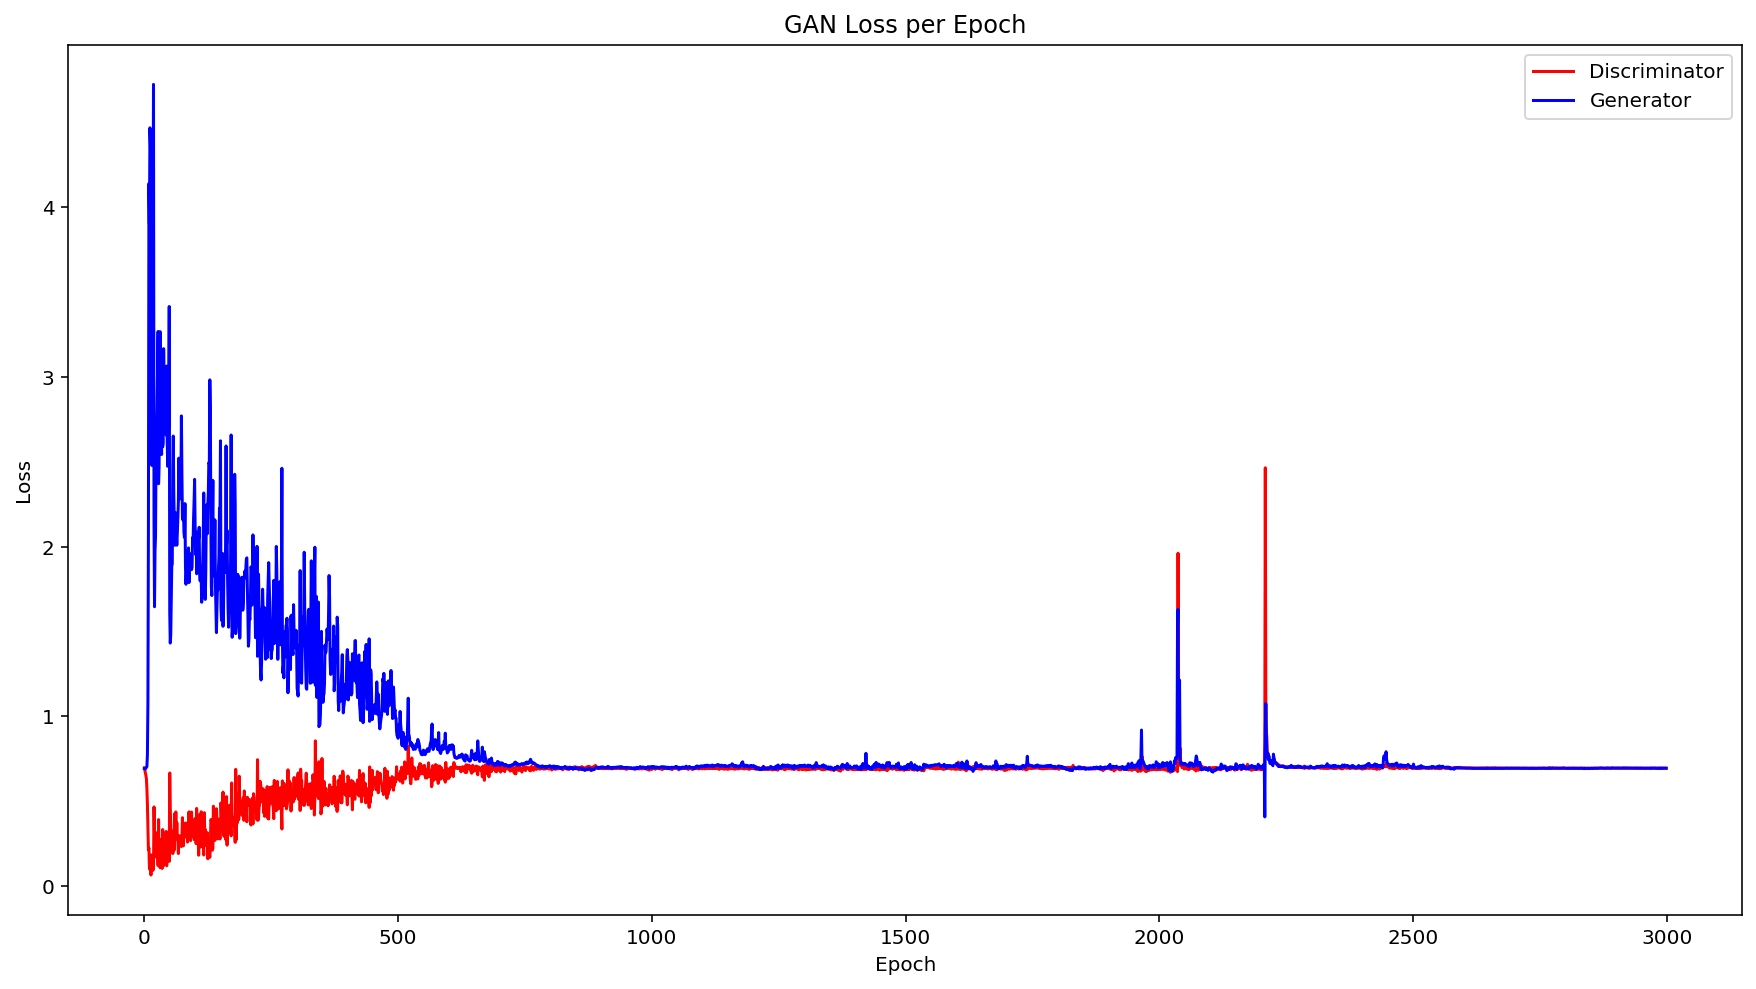

In [51]:
#we will visialize the plot for both the generator and discriminator losses
plt.figure(figsize = (15,8))
plt.plot(model_train[0], c = 'red')
plt.plot(model_train[1], c = 'blue')
plt.title("GAN Loss per Epoch")
plt.legend(['Discriminator', 'Generator'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('GAN_Loss_per_Epoch_final.png', transparent = True)
plt.show()

It can be observed from the above plot that at the start the losses for both generator and discriminator are far apart. At the start, loss for the discriminator is too low, meaning the discriminator is able to easily distinguish fake music geenrated by generator from the real one. And for the same reason the loss for the generator is too high at the start. But as the training progresses, the losses for both the generator and discriminator are starting to converge and around after 500 epochs or so, the losses for both the generator and discriminator have totally converged which means that the discriminator is finding it difficult to differentiate between the fake music produced by the generator and the real music. So discriminator is able to distinguish with 50% probability the difference between the generated music and actual music. 